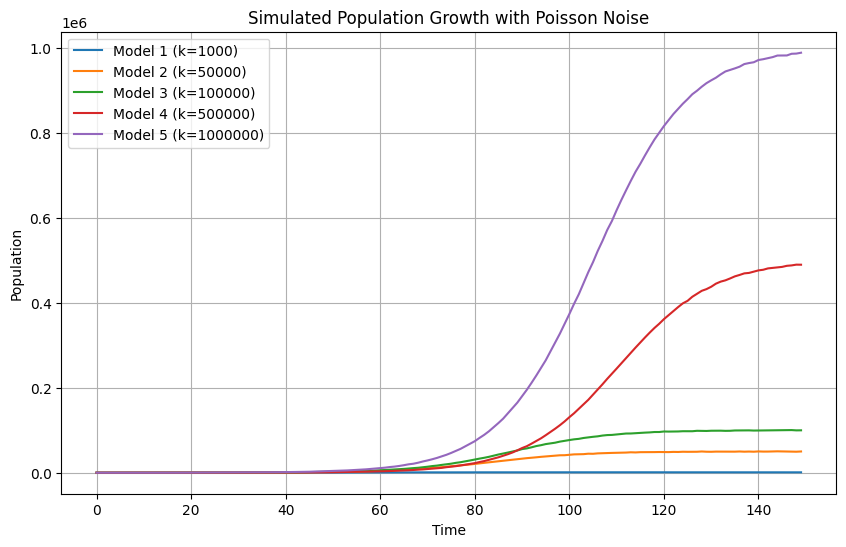

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

def growthEQ(t, y):
    r = 0.1
    return r*y*(1 - (y/carrying_cap))

num_of_models = 5
time = 150
states = [5, 12, 15, 8, 27]
k_vals = [1000, 50_000, 100_000, 500_000, 1_000_000]
data = np.empty([5, time])


for i in range(num_of_models):
    if len(states) != num_of_models or len(k_vals) != num_of_models:
        print("Either initial states or k_vals does not equal the number of models.")
        exit()

    init_state = [states[i]]
    carrying_cap = k_vals[i]
    sol = solve_ivp(fun=growthEQ, 
                    t_span=[0, time], 
                    y0=init_state, 
                    t_eval=range(time))
    data[i] = np.random.poisson(sol.y[0])


# Save to CSV
file_path = '../datasets/resample_experiment_time_series.csv'
df = pd.DataFrame(data.T, columns=[f'Model {i+1} (k={k})' for i, k in enumerate(k_vals)])
df.to_csv(file_path, index=False)


# Create plot for data 
plt.figure(figsize=(10, 6))
for i in range(num_of_models):
    plt.plot(np.arange(time), data[i], label=f'Model {i+1} (k={k_vals[i]})')

plt.title('Simulated Population Growth with Poisson Noise')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

## Increasing the rate

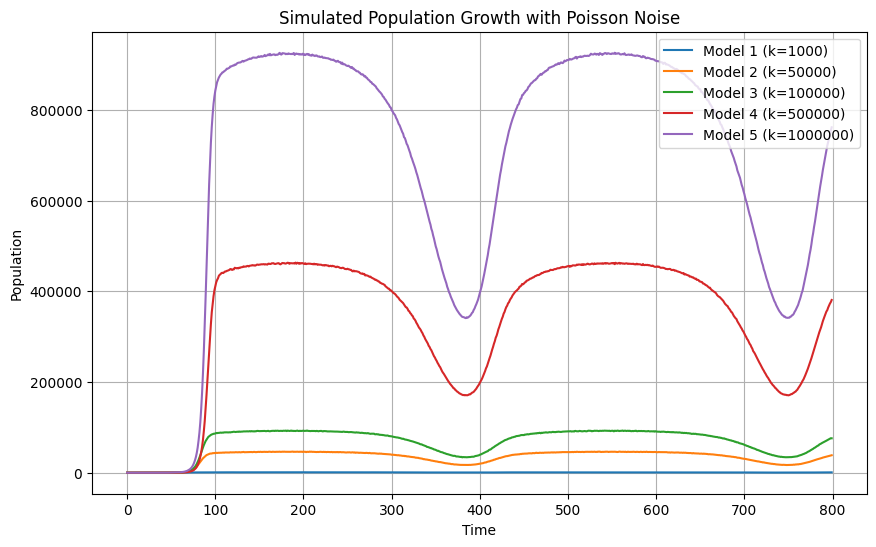

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd


d=365
t=np.linspace(0,2*d,2*d+1)
def effBeta(t):
    return 0.3*(1.2-np.cos(t/d*2*np.pi))


def growthEQ(t, y):
    r = effBeta(t)
    mu = 0.05
    return r*y*(1 - (y/carrying_cap)) - mu*y

num_of_models = 5
time = 800
states = [5, 12, 15, 8, 27]
k_vals = [1000, 50_000, 100_000, 500_000, 1_000_000]
data = np.empty([num_of_models, time])


for i in range(num_of_models):
    if len(states) != num_of_models or len(k_vals) != num_of_models:
        print("Either initial states or k_vals does not equal the number of models.")
        exit()

    init_state = [states[i]]
    carrying_cap = k_vals[i]
    sol = solve_ivp(fun=growthEQ, 
                    t_span=[0, time], 
                    y0=init_state, 
                    t_eval=range(time))
    data[i] = np.random.poisson(sol.y[0])


# Save to CSV
file_path = '../datasets/resample_experiment_time_series.csv'
df = pd.DataFrame(data.T, columns=[f'Model {i+1} (k={k})' for i, k in enumerate(k_vals)])
df.to_csv(file_path, index=False)


# Create plot for data 
plt.figure(figsize=(10, 6))
for i in range(num_of_models):
    plt.plot(np.arange(time), data[i], label=f'Model {i+1} (k={k_vals[i]})')

plt.title('Simulated Population Growth with Poisson Noise')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()